# Classifiez automatiquement des biens de consommation - partie textuelle - modélisation non supervisée

## 1. Introduction

__Sommaire de tous les notebooks de ce dossier__

1. Analyse exploratoire des données textuelles
2. Analyse exploratoire des données visuelles__
3. __Prétraitement, feature extraction et faisabilité textuelle - premiers modèles__  
4. Prétraitement, feature extraction et faisabilité visuelle - premiers modèles

Dans ce notebook, nous allons traiter du troisième point. 

### Les critères à remplir dans ce notebook
   1. __Prétraiter des données textes pour obtenir un jeu de données exploitable.__
      - [ ] CE1 Vous avez nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules)
      - [x] CE2 Vous avez écrit une fonction permettant de “tokeniser” une phrase.
      - [x] CE3 Vous avez écrit une fonction permettant de “stemmer” une phrase.
      - [x] CE4 Vous avez écrit une fonction permettant de “lemmatiser” une phrase.
      - [ ] CE5 Vous avez construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.
      - [ ] CE6 Vous avez testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.
      - [ ] CE7 Vous avez, en complément de la démarche de type “bag-of-words”, mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).
      - [ ] CE8 Vous vous êtes assurés que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite.

   2. __Mettre en œuvre des techniques de réduction de dimension.__
      - [ ] CE1 Vous avez justifié la nécessité de la réduction de dimension. 
      - [ ] CE2 Vous avez appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 
      - [ ] CE3 Vous avez justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP).  
 
   3. __Représenter graphiquement des données à grandes dimensions.__
      - [ ] CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique).
      - [ ] CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).
      - [ ] CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

## Préparation de l'environnement

__Importation des librairies, fonctions et le jeu de données__

In [50]:
import sys
sys.path.append("/Users/Audrey/Documents/github_repositories/DS_Master_project_6/")
from internal_lib import PATH_input
#(PATH_input, RANDOM_STATE, flipkart_stopword, n_clusters, true_label, PATH_output)
#import my_packages

ImportError: attempted relative import with no known parent package

__Importation des librairies et du jeu de données__

In [ ]:
import pandas as pd
import numpy as np
#from scipy.stats import randint as sp_randint
from sklearn.pipeline import Pipeline
# librairies pour la réduction des dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

 
from internal_lib import (tokenize, stemming, lemmatisation, transform_bow_fct, transform_bow_stem_fct,
 transform_bow_lemm_fct, cleaning_text, transform_dl_fct,
 bold_print, variance_needed_plot, premiere_evaluation_graphique,
 visu_fct, eval_metrics_df, conf_mat_transform, confusion_matrix_plot,
 classification_report_df, error_plot)

from nltk import word_tokenize

from joblib import dump, load


# Transformation de TSNE pour être compatible avec le reste du pipeline 
# ce dernier ne supportant pas la fonction predict
class TSNETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, perplexity=30, n_iter=2000, random_state=None):
        self.n_components = n_components
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.random_state = random_state
        self.tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=random_state)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.tsne.fit_transform(X)

# Définir la fonction de transformation qui convertit la sortie de TSNE en un tableau de caractéristiques
def tsne_features(tsne_output):
    return tsne_output[:, :2]

__Mise en place du format de l'affichage des données__

In [ ]:
# Pour afficher l'ensemble du texte dans une cellule de dataframe
pd.set_option('display.max_colwidth', None)

__Importation du jeu de données textuel__

In [ ]:
# Réimportation uniquement des données textuelles nécessaires
df = pd.read_csv(PATH_input+'flipkart_com-ecommerce_sample_1050.csv')    
df['CATEGORY'] = df['product_category_tree'].map(lambda x: x.split("[\"")[1].split(" >>", 1)[0])
df = df[['CATEGORY', 'description']]
df.columns = ['CATEGORY', 'TEXT']
df[df.index==222]

In [ ]:
%%time
# Prétraitement textuels

# tokenisation
df['TOKEN'] = df['TEXT'].map(tokenize)

# stemming
df['STEM'] = df['TEXT'].map(stemming)

# Lemmatisation
df['LEMM'] = df['TEXT'].map(lemmatisation)

# tokenisation + transformation en phrases
df['sentence_bow'] = df['TEXT'].map(transform_bow_fct)

# stemming + transformation en phrases
df['sentence_stem'] = df['TEXT'].map(transform_bow_stem_fct)

# Lemmatisation + transformation en phrases
df['sentence_lemm'] = df['TEXT'].map(transform_bow_lemm_fct)

# tokenisation pour modèle DL + transformation en phrases
df['sentence_dl'] = df['TEXT'].map(transform_dl_fct)

In [ ]:
# Taille maximum des features selon les techniques de prétraitement du texte
df['length_bow'] = df['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
df['length_dl'] = df['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
df['length_bow_lemm'] = df['sentence_lemm'].apply(lambda x : len(word_tokenize(x)))
df['length_bow_stem'] = df['sentence_stem'].apply(lambda x : len(word_tokenize(x)))

print("Nombre de mots maximum dans le bag-of-words avec la méthode de tokénisation :", df['length_bow'].max())
print("Nombre de mots maximum dans le bag-of-words avec la méthode de lemmatisation :", df['length_bow_lemm'].max())
print("Nombre de mots maximum dans le bag-of-words avec la méthode de stemming :", df['length_bow_stem'].max())
print("Nombre de mots maximum pour le deep learning (DL) avec la méthode de tokénisation :", df['length_dl'].max())

In [ ]:
# Premier exemple pour chaque type de modification (CE6)
row_index = 220
example_df = pd.DataFrame({'0. TEXT': df['TEXT'][row_index], 
                           '1. CLEAN_TEXT': cleaning_text(df['TEXT'][row_index]),
                           '2. TOKENIZATION': str(tokenize(df['TEXT'][row_index])),
                           '2B. TOKENIZED DOC': str(transform_bow_fct(df['TEXT'][row_index])),
                           '3. STEMMING': str(stemming(df['TEXT'][row_index])),
                           '3B. STEMMATIZED DOC': str(transform_bow_stem_fct(df['TEXT'][row_index])),
                           '4. LEMMATIZATION': str(lemmatisation(df['TEXT'][row_index])),
                           '4B. LEMMATIZED DOC': str(transform_bow_lemm_fct(df['TEXT'][row_index])),
                          }, index=['Test on sample 220']).rename_axis('Type de modification').T
example_df

{'elegance': 7482, 'polyester': 16630, 'multicolor': 14195, 'abstract': 62, 'eyelet': 8006, 'door': 6951, 'curtain': 5848, 'floral': 8594, 'curtainelegance': 5862, 'height': 10586, 'pack': 15551, 'this': 21719, 'enhances': 7622, 'the': 21208, 'look': 12835, 'interiors': 11490, 'made': 13062, 'from': 9189, 'high': 10679, 'quality': 17395, 'fabric': 8024, 'style': 20512, 'stitch': 20305, 'with': 24085, 'metal': 13706, 'ring': 18169, 'makes': 13190, 'room': 18279, 'environment': 7696, 'romantic': 18262, 'and': 647, 'loving': 12963, 'ant': 1191, 'wrinkle': 24557, 'anti': 1202, 'shrinkage': 19297, 'have': 10468, 'elegant': 7489, 'apparance': 1311, 'give': 9740, 'your': 24817, 'home': 10802, 'bright': 3298, 'modernistic': 13929, 'appeal': 1317, 'these': 21643, 'designs': 6473, 'surreal': 20789, 'attention': 1695, 'sure': 20741, 'steal': 20215, 'hearts': 10557, 'contemporary': 5232, 'valance': 22916, 'curtains': 5864, 'slide': 19649, 'smoothly': 19749, 'when': 23770, 'you': 24730, 'draw': 700

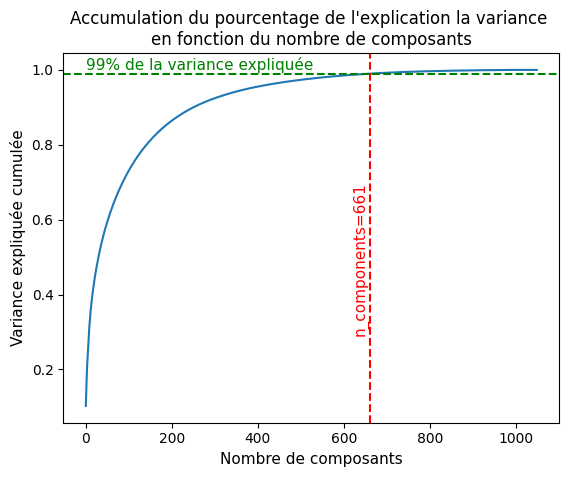

Pipeline(steps=[('preprocess',
                 CountVectorizer(max_df=0.98, ngram_range=(1, 2),
                                 stop_words=['', 'product', 'cm', 'shipping',
                                             'flipkart', 'online', 'products',
                                             'features', 'specifications',
                                             'free', 'delivery', 'india',
                                             'prices', 'price', 'com', 'cash',
                                             'key', 'rs', 'great', 'sales',
                                             'genuine', 'flipkartcom',
                                             'discounts', 'buy'])),
                ('reducDimension', TruncatedSVD(n_components=4000))])

Pipeline(steps=[('preprocess',
                 CountVectorizer(max_df=0.98, ngram_range=(1, 2),
                                 stop_words=['', 'product', 'cm', 'shipping',
                                             'flipkart', 'online', 'products',
                                             'features', 'specifications',
                                             'free', 'delivery', 'india',
                                             'prices', 'price', 'com', 'cash',
                                             'key', 'rs', 'great', 'sales',
                                             'genuine', 'flipkartcom',
                                             'discounts', 'buy'])),
                ('reducDimension', TruncatedSVD(n_components=661)),
                ('tsne', TSNETransformer(random_state=42)),
                ('tsne_features',
                 FunctionTransformer(func=<function tsne_features at 0x7f84509ccaf0>)),
                ('cluster', KMeans(n_clusters=7, random_state=42))])

In [37]:
# éléments à fixer pour ce modèle
feat_ = 'sentence_bow'
model_name_ = 'cv_bow_tsne_01'
output_path_model = f'{PATH_output}non_supervised_model/'
output_path_results = f'{PATH_output}non_supervised_results/'

# Technique de preprocessing de langage choisi
preprocessing_ = CountVectorizer(stop_words=flipkart_stopword,
                                 ngram_range=(1,2), #combine de mot unigrammes (un mot) et de bigramme (mot composé de 2 mots)
                                 min_df=1, #min de deux mots
                                 max_df=0.98,
                                 #vocabulary=custom_vocab
                                )

#%%time ==> create time 
# Création d'un premier pipeline permettant de calculer le nombre de dimension 
# à garder pour conserver une explication de la variance à une hauteur de 99%
# pour le vrai pipeline et ainsi diminuer le temps d'éxecution de la pipeline
pipeline_ = Pipeline([
    ('preprocess', preprocessing_),
    ('reducDimension', TruncatedSVD(n_components=4000)),
])

# Entraîner le pipeline
pipeline_ = pipeline_.fit(df[feat_])

# Affichage du vocabulaire
vocab = preprocessing_.vocabulary_
print(vocab)

# Calculer la variance expliquée cumulée
explained_variance = pipeline_.named_steps['reducDimension'].explained_variance_ratio_
cumulative_var = np.cumsum(explained_variance)

# Trouver le nombre de dimensions nécessaires pour atteindre 0.99 de la variance expliquée
n_components = np.argmax(cumulative_var >= 0.99) + 1

# Représentation graphique du nombre de dimensions minimums pour pouvoir 
# conserver 99% de l'explication de la variance observée
variance_needed_plot(cumulative_var=cumulative_var, 
                     n_components=n_components)

# Entraîner le pipeline
pipeline_ = pipeline_.fit(df[feat_])
display(pipeline_)

# Créer le pipeline
pipeline_ = Pipeline([
    # Preprocessing: construction des features
    ('preprocess', preprocessing_),
    # Réduction des dimensions pour ne garder que 99% de l'explication de la variance
    ('reducDimension', TruncatedSVD(n_components=n_components)),
    # Réduction TSNE 
    ('tsne', TSNETransformer(n_components=2, 
                             n_iter=2000, 
                             random_state=RANDOM_STATE)),
    # Transformation pour être compatible avec le reste du pipeline
    ('tsne_features', FunctionTransformer(tsne_features)),
    # Création des 7 clusters
    ('cluster', KMeans(n_clusters=7, 
                       random_state=RANDOM_STATE)),
])

#%%time ==> Add time 
# Entraîner le pipeline
pipeline_ = pipeline_.fit(df[feat_])
display(pipeline_)

In [39]:
# Transformation du pipeline
X_embedded = pipeline_.transform(df[feat_])

# Création de features à partir du pipeline
preprocess_ = pipeline_.named_steps['preprocess']
features_ = preprocess_.fit_transform(df[feat_])
print([features_.toarray().ravel()])

#%%time ==> Add time
# Prédiction des labels des clusters
pred_label = pipeline_.predict(df[feat_])

# Transformation des pred_label pour les faire matcher avec les true_label 
pred_label = conf_mat_transform(true_label, pred_label)

[array([0, 0, 0, ..., 0, 0, 0])]
Correspondance des clusters :  [1 0 4 6 3 5 2]


In [40]:
# Première évaluation - visualisation sur les catégories prédits 
premiere_evaluation_graphique(pred_label)


NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:

# Représentation graphique des données (CE1)
visu_fct(X_embedded, true_label, pred_label)

# Création d'une ligne de dataframe contenant les quatre métriques d'évaluation 
# que sont V-measure, la complétude, homogénéité et l'ARI
results_ = eval_metrics_df(true_label, pred_label)

# Enregistrement des résultats dans un tableau
results_.to_csv(f'{output_path_results}{model_name_}_results.csv', index=False)
# Evaluation des résultats
display(results_)

## Evaluation plus poussée si l'ARI est correct
# Observation sur la différence entre la réelle catégorie et sa prédiction
error_plot(true_label, pred_label)

# Visualiser de la matrice de confusion
confusion_matrix_plot(true_label, pred_label)

# Affichage des métriques d'évaluation precision, recall, f1-score, support
classification_report_df(true_label, pred_label)

# Enregistrement du pipeline
dump(pipeline_, f"{output_path_model}{model_name_}_model.joblib")